# Session 20 - Dtable Diffusion Deep dive

In [1]:
#Installations
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate
#!pip install ipywidgets

##### Hugging face sign in

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, StableDiffusionPipeline
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

#### Loading the Stable diffuion pipeline

In [3]:
model_nm = "CompVis/stable-diffusion-v1-4"

output_dir="sd-concept-output"
pipe = StableDiffusionPipeline.from_pretrained(model_nm).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Fetching the AE, UNET, CLIP models from Stable diffusion pipleine

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = pipe.vae
tokenizer = pipe.tokenizer

# Load the tokenizer and text encoder to tokenize and encode the text.
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder =pipe.text_encoder

# The UNet model for generating the latents.
unet = pipe.unet

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

#### Deepdive into the Stable Diffusion pipeline

/tmp/ipykernel_32/4195205535.py:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

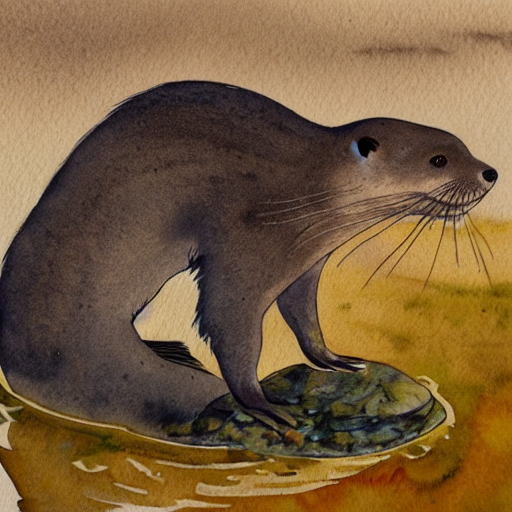

In [5]:
# Some settings
prompt = ["A watercolor painting of an otter"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

### Assignment Part - 1 - Get different styles with textual inversions

##### Style-1

  0%|          | 0/100 [00:00<?, ?it/s]

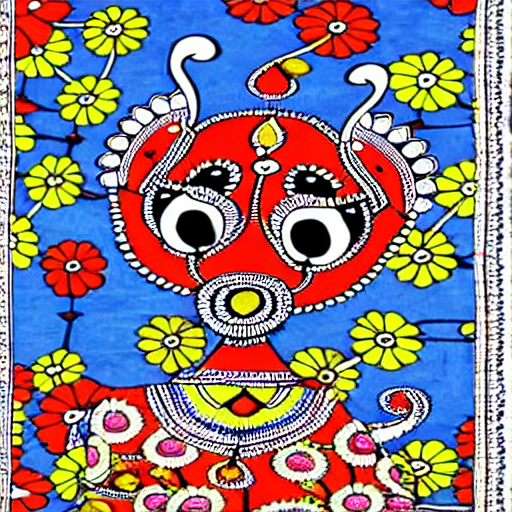

In [6]:
pipe.load_textual_inversion("sd-concepts-library/madhubani-art")
prompt = "a puppy in <madhubani-art> style"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
madhubani_puppy = images[0]
madhubani_puppy

##### Style-2

  0%|          | 0/100 [00:00<?, ?it/s]

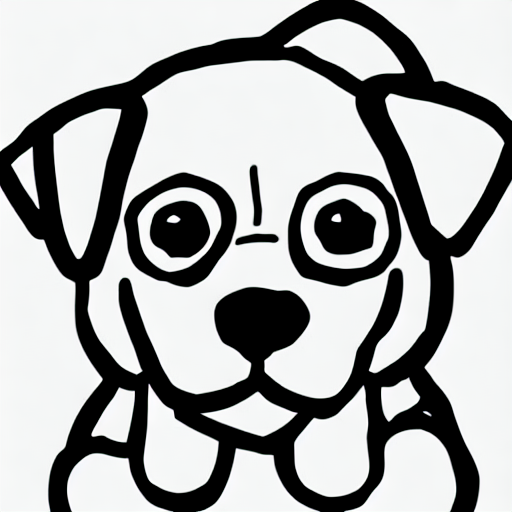

In [7]:
prompt = "a puppy in <line-art> style"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
images[0]
simple_puppy = images[0]
simple_puppy

##### Style-3

  0%|          | 0/100 [00:00<?, ?it/s]

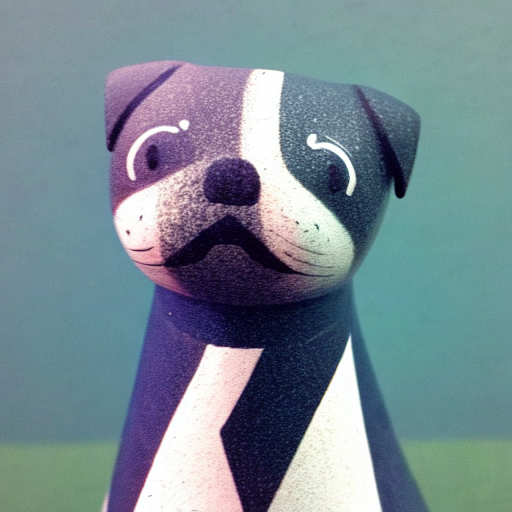

In [17]:
pipe.load_textual_inversion("sd-concepts-library/cat-toy")
prompt = "a puppy in <cat-toy> style"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
pokemon_puppy = images[0]
pokemon_puppy

##### Style-4

  0%|          | 0/100 [00:00<?, ?it/s]

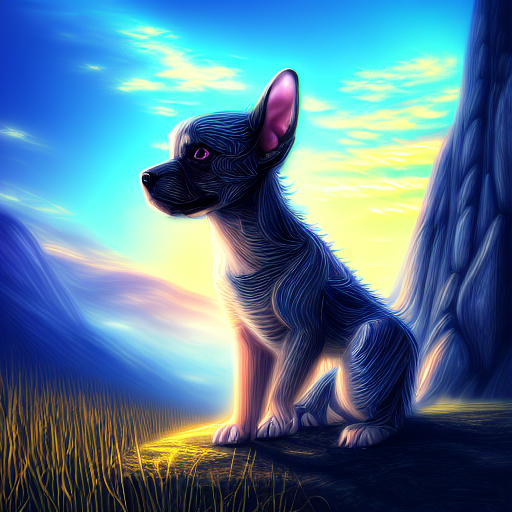

In [8]:
pipe.load_textual_inversion("sd-concepts-library/concept-art") 
prompt = "a puppy in <concept-art>"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
concept_art_puppy = images[0]
concept_art_puppy

#### Some utility functions

In [9]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [10]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers

### Assignment Part 2 - Custom Loss

In [11]:
def rgb_to_hsv(rgb_tensor):
    from PIL import Image
    import torchvision.transforms.functional as F
    hsv_images = []
    for i in range(rgb_tensor.size(0)):
        pil_image = F.to_pil_image(rgb_tensor[i])
        hsv_image = pil_image.convert('HSV')
        hsv_tensor = F.to_tensor(hsv_image)
        hsv_images.append(hsv_tensor)
    return torch.stack(hsv_images, dim=0)

def saturation_loss_NotWorking(images, reference_mean_saturation=0.9):
    # Convert RGB images to HSV
    hsv_images = rgb_to_hsv(images)

    # Extract the saturation channel (index 1 in HSV color space)
    saturation_channels = hsv_images[:, 1, :, :]

    # Calculate the mean saturation value for the batch
    mean_saturation = saturation_channels.mean()

    # Compute the loss
    loss = torch.abs(mean_saturation - reference_mean_saturation)

    return loss

def saturation_loss(images):
    # Calculate saturation for each pixel in the input image tensor
    max_vals, _ = torch.max(images, dim=1, keepdim=True)
    min_vals, _ = torch.min(images, dim=1, keepdim=True)
    saturation = (max_vals - min_vals) / max_vals.clamp(min=1e-7)  # Avoid division by zero
    
    # Calculate mean saturation across the image
    mean_saturation = torch.mean(saturation, dim=(2, 3))  # Average over width and height
    
    # Calculate the loss as the negative mean saturation (proportional to saturation)
    #loss = torch.abs(saturation - 0.9).mean()
    
    return mean_saturation/10000

#### Without Cutom Loss

/tmp/ipykernel_32/604497341.py:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/200 [00:00<?, ?it/s]

0 loss: 0.0
10 loss: 0.0
20 loss: 0.0
30 loss: 0.0
40 loss: 0.0
50 loss: 0.0
60 loss: 0.0
70 loss: 0.0
80 loss: 0.0
90 loss: 0.0
100 loss: 0.0
110 loss: 0.0
120 loss: 0.0
130 loss: 0.0
140 loss: 0.0
150 loss: 0.0
160 loss: 0.0
170 loss: 0.0
180 loss: 0.0
190 loss: 0.0


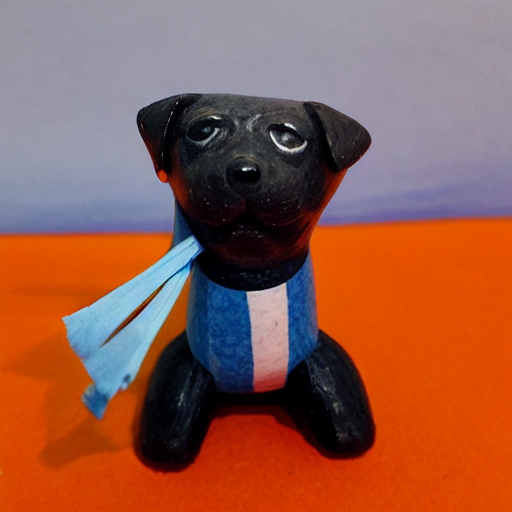

In [34]:
prompt = 'a puppy in <cat-toy> style' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 200  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
saturation_loss_Scale = 0 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample
        scheduler._step_index = scheduler._step_index - 1

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = saturation_loss(denoised_images) * saturation_loss_Scale
        #loss = loss.detach().requires_grad_()
        #print('loss.grad_fn = {}'.format(grad_fn))

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


without_custom_loss_image = latents_to_pil(latents)[0]
without_custom_loss_image

#### With Custom loss

/tmp/ipykernel_32/2657035590.py:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/200 [00:00<?, ?it/s]

0 loss: 0.00011518273095134646
10 loss: 0.0014144915621727705
20 loss: 0.1549978107213974
30 loss: 0.06321032345294952
40 loss: 0.025170857086777687
50 loss: 0.004506136756390333
60 loss: 0.004532365128397942
70 loss: 0.003578502917662263
80 loss: 0.0027207271195948124
90 loss: 0.005361892748624086
100 loss: 0.007825606502592564
110 loss: 0.012447657063603401
120 loss: 0.012005367316305637
130 loss: 0.014615193009376526
140 loss: 0.013524563051760197
150 loss: 0.014191016554832458
160 loss: 0.012890479527413845
170 loss: 0.017020683735609055
180 loss: 0.022678881883621216
190 loss: 0.02270429953932762


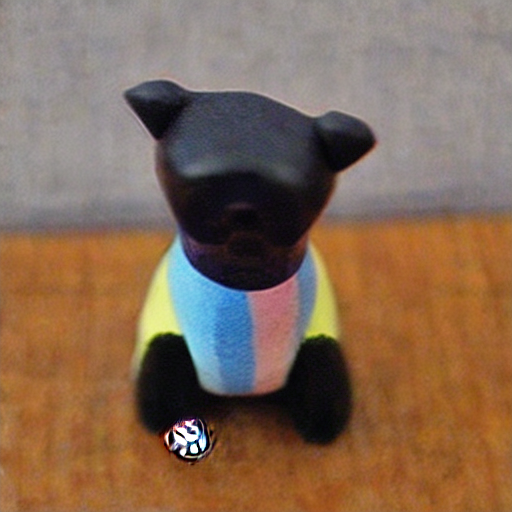

In [35]:
prompt = 'a puppy in <cat-toy> style' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 200  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
saturation_loss_Scale = 2 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample
        scheduler._step_index = scheduler._step_index - 1

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = saturation_loss(denoised_images) * saturation_loss_Scale
    
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


with_custom_loss_image = latents_to_pil(latents)[0]
with_custom_loss_image

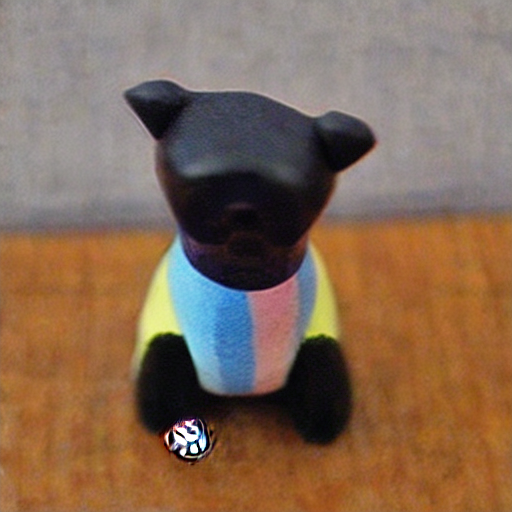

In [37]:
#Puppy in pokemon style - No custom loss
with_custom_loss_image

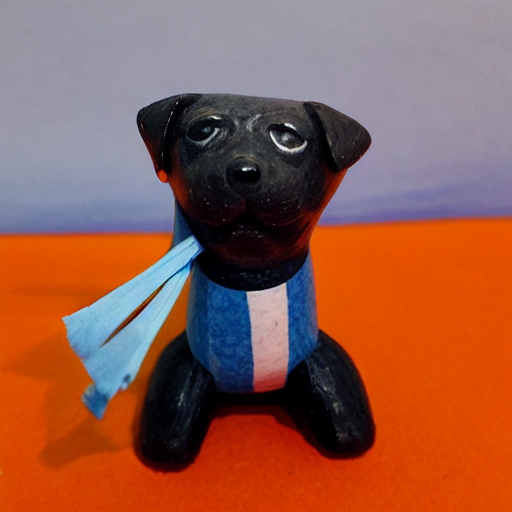

In [36]:
#Puppy in pokemon style - with custom loss
without_custom_loss_image

### Notice how the saturation of image is being reduced with  custom loss. The custom loss further nudges the image to have less saturaion